Didn't miss writing a notebook for statistics that much :|

First things first we need to change the extensions of the matches to txt from tcx (the export format of choice of the garmin connect app) but first some imports

In [2]:
import os
import numpy as np
import pandas as pd
import csv
import chess
import chess.pgn
import chess.engine
from stockfish import Stockfish
import matplotlib.pyplot as plt


In [2]:
def change_ext(cartella, old_ext, new_ext):
    for root, dirs, files in os.walk(cartella):
        # print(os.getcwd())
        for f in files:
            filename = os.fsdecode(f)
            
                
            if filename.endswith(old_ext):
                name, ext = os.path.splitext(filename)
                
                new_name = name + new_ext
                jpath = os.path.join(root,new_name)
                os.rename(os.path.join(root,filename), jpath)
                print(f"renamed {os.path.join(root,filename)} to {jpath}")

change_ext("games", ".tcx", ".txt")

Now we have to import the data from the [Portable Game Notation or pgn](https://en.wikipedia.org/wiki/Portable_Game_Notation)
and read the heartbeats of both white and black (in the games where they are both available) in order to create a 3d dataframe for every game and then to visualize the data we are working with. To process the portable game notation we will use the following cell of code.

In [3]:
### UTILS FOR READING THE ACTIVITIES

def calctime(start,curr):
    c = [int(x) for x in curr.split(":")]
    s = [int(x) for x in start.split(":")]
    return ((c[0] - s[0]) * 60 + (c[1] - s[1])) * 60 + (c[2] - s[2])

def read_activity(game):
    with open(game) as f:
        lines = f.readlines()
        hr = []
        time = []
        for s in lines:
            if "<Value>" in s:
                hr.append(int(s.strip()[s.strip().find(">") + 1:s.strip().rfind("<")]))
            if "<Time>" in s:
                s = s.strip()[3:]
                if not time:
                    start = s.strip()[s.strip().find("T") + 1:s.strip().rfind(".")]
                    
                time.append(calctime(start, s.strip()[s.strip().find("T") + 1:s.strip().rfind(".")]))
        
        #print(f"hr is {hr}, and time is {time}")
        hr = hr[2:]
        if len(time) - 1 != time[-1]:
            diz = {time[i]: hr[i] for i in range(min(len(hr), len(time)))}
            last_battito = 0
            hr = []
            tempo = []
            keys = list(diz.keys())
            
            print(time[-1] + 1)
            prev = -1
            last_battito = 0
            for s in range(time[-1] + 1):
                if s in diz:
                    
                    hr.append(diz[s])
                    tempo.append(s)
                    last = (diz[s], s)
                    indice_s = keys.index(s)
                    if indice_s + 1 < len(keys):
                        next_s = keys[indice_s + 1]
                        next = (diz[keys[indice_s + 1]], next_s)
                    
                    
                    
                else:
                    total_gap = s - last[1] + next[1] - s
                    if total_gap <= 0:
                        
                        hr.append(last_battito)
                        tempo.append(s)
                        continue
                    
                    weight_next = (s-last[1]) * 100 / total_gap
                    weight_last = 100 - weight_next 
                    est_battito = (weight_last * float(last[0]) + weight_next * float(next[0])) / 100
                    last_battito = est_battito
                    
                    hr.append(round(est_battito))
                    tempo.append(s)
                    
            delta = sum(hr[:10]) // 10
            hrd = np.array(hr) - delta
            
            return list(zip(hrd,tempo, hr))
                
        delta = sum(hr[:10]) // 10
        hrd = np.array(hr) - delta
        return list(zip(hrd,time, hr))
        
#read_activity("games/partita_0814-2/white.txt")

In [5]:
lista = [(1,0),(2,0),(3,0),(4,0),(5,0),(3,0),(2,0),(1,0)]
delta = sum([lista[i][0] for i in range(3)]) // 3


In [4]:
### UTILS FOR READING THE PGN

#this method takes as input the board and the last move so to update the board and compute the evaluation
def get_evaluation(board,move):

    stockfish = Stockfish("/usr/local/Cellar/stockfish/15/bin/stockfish")     #if no parameter passed, takes as input the executable file called stockfish from the same directory, if found
    board.push_san(move)        #insert the move in the board
    stockfish.set_fen_position(board.fen())  #bpard.fen() applies a PGN to FEN conversion
    engine = chess.engine.SimpleEngine.popen_uci("stockfish")
    info = engine.analyse(board, chess.engine.Limit(time=0.1))     #gets the infos of the game
    
    #if the position on the board is not a mate the score is in centipawns, then it's divided by 100 to get the actual score
    #Gets the score from White’s point of view
    if chess.engine.PovScore.is_mate(info['score']):
        eval = chess.engine.PovScore.white(info['score'])
    else:
        eval = int(str(chess.engine.PovScore.white(info['score'])))/100

    return board, eval      #returns the board updated and the evaluation of the position

In [3]:
def get_timestamps(file):
    timestamps = []
    file = file[:-3] + "txt"
    with open(file, "r") as f:
        file_read = f.read()
        lista = file_read.split("%")
        
        
        for el in lista:
            if el[0:4] == "time":
                num = ""
                flag = False
                for i  in range(len(el)):
                    while el[i].isdigit():
                        num += el[i]
                        i += 1
                        flag = True
                    if flag:
                        timestamps.append(int(num)/10)
                        break
    return timestamps
            
get_timestamps("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src/games/partita_0816-7/tommidim_vs_roccot01_2022.08.16.txt")

[0.1,
 0.1,
 3.4,
 0.9,
 13.6,
 1.9,
 2.8,
 9.8,
 3.5,
 11.4,
 13.7,
 9.5,
 13.0,
 19.4,
 12.9,
 11.3,
 2.5,
 1.7,
 17.7,
 5.5,
 10.1,
 2.7,
 0.6,
 4.8,
 21.2,
 4.4,
 0.1,
 10.4,
 2.5,
 22.1,
 10.8,
 12.1,
 23.1,
 6.5,
 1.6,
 20.3,
 7.7,
 49.1,
 27.4,
 10.1,
 3.5,
 16.7,
 6.2,
 8.7,
 37.7,
 34.0,
 49.1,
 9.7,
 26.9,
 29.2,
 11.8,
 1.4,
 12.9,
 22.8,
 17.7,
 17.7,
 12.9,
 20.9,
 54.3,
 12.6,
 6.0,
 1.6,
 0.4,
 1.0,
 0.4,
 26.9,
 3.7,
 7.1,
 25.2,
 15.9,
 42.5,
 7.4,
 15.1,
 16.0,
 10.7,
 21.5,
 7.9,
 13.1,
 21.0,
 1.7,
 2.0,
 22.3,
 1.1,
 19.5,
 6.0,
 18.0,
 19.3,
 12.7,
 0.7,
 3.9,
 2.0,
 6.2,
 3.8,
 1.3,
 3.1,
 3.2,
 7.7,
 1.5,
 0.1,
 1.1]

In [4]:
def get_moves(file):
    moves = []
    file = file[:-3] + "txt"
    with open(file, "r") as f:
        file_read = f.read()
        lista = file_read.split("{")
        return [[elem.strip()]  for el in lista for elem in el[-7:].split() if "." not in elem][:-1]
        
#get_moves("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src/partite_confronto/partita_timestamp.txt")

In [9]:
#read_pgn takes as input the name of the file pgn containing the game and returns a dataframe
def read_pgn(game_name): 
    old = False
    if ("05.29" in game_name or "05.25" in game_name or "clk" in game_name) and "x" not in game_name:
        old = True
    #opens and reads the pgn file
    if not old:
        timestamps = get_timestamps(game_name)
    pgn = open(game_name) 
    
    game = chess.pgn.read_game(pgn)
    
    print(old)
                                   
    array = []      #initialize the array that will contain the data
    index_values = [] 
    i=0
    time_white = -0.1      #to keep track of the time for each player
    time_black = 0      #to keep track of the time for each player
    board = chess.Board()       #initialize the chessboard
    
    #iterate through the moves
    for node in game.mainline():        
        
        move = str(node.move)       #represents the last move
        board,evaluation = get_evaluation(board,move)       #the get_evaluation method returns the updated board and the evaluation of the current position
        
        newboard = board.copy()
        
        if i%2 == 0:        #if the white is moving we update his time
            index_values.append("white")
            if old:
                time_white = 600 - node.clock()
                array.append([str(node.move),round(600 - node.clock(),4),round(time_white+time_black,4),evaluation, str(newboard.fen())])   
            else:
                time_white += timestamps[i]
                array.append([str(node.move),round(time_white,4),round(time_white+time_black,4),evaluation, str(newboard.fen())])
            
           
        else:           #if the black is moving we update his time
            index_values.append("black") 
            if old:
                time_black = 600 - node.clock()
                array.append([str(node.move),round(600 - node.clock(),4),round(time_white+time_black,4),evaluation, newboard.fen()])   
            else:
                time_black += timestamps[i]
                array.append([str(node.move),round(time_black,4),round(time_white+time_black,4),evaluation, newboard.fen()])
        # display(newboard)
        #evaluation = get_evaluation(board,move)
        #we append an element in the array (a row in the dataframe) with move, time the player used, total time since the game started and evaluation of the position
        # if str(evaluation)[:2] == "#+":
        #     evaluation = 15
        # elif str(evaluation)[:2] == "#-":
        #     evaluation = -15
        
            
        i += 1
        
    
    
    
    
    res = []
    j = 0
    #df = pd.DataFrame(data = array, index = index_values, columns = column_values) 
    
    tub = 0
    tuw = 0
    pos = 0.0
    for i in range(int(array[-1][2]) + 2):
        mosse = []
        
        while j < len(array):
            if float(array[j][2]) > float(i):
                break
            

            pos = array[j][3]
            boardy = array[j][-1]
            # display(boardy)
            mosse.append(array[j][0])
            if j % 2 == 0:
                tuw = array[j][1]
            elif j % 2 != 0:
                tub = array[j][1]
            j += 1
            if j > len(array):
                break
        res.append([i, pos, (tuw,tub), mosse, boardy])
    
    print("\n\n The tail of res is:\n")
    print(res)    
    print("\n\n The tail of array is:\n")
    print(array)
    
         
        
    #create a dataframe

    return res,array


# res,array = read_pgn("games/partita_0529-1/roccot01_vs_tommidim_2022.05.29.pgn")

In [10]:
# column_values = ['move','time','real time','evaluation'] #create the columns names
    
# res = []
# j = 0
#     #df = pd.DataFrame(data = array, index = index_values, columns = column_values) 
    
# tub = 0
# tuw = 0
# pos = 0.0
# for i in range(round(array[-1][2]) + 1):
#     mosse = []
    
#     while j < len(array):
        
#         if int(array[j][2]) > i:
#             break
        
#         # print(f"array[j] is {array[j]}")
#         pos = array[j][3]
#         mosse.append(array[j][0])
#         if j % 2 == 0:
#             tuw = array[j][1]
#         elif j % 2 != 0:
#             tub = array[j][1]
#         j += 1
        
#         if j >= len(array):
#             break
#     res.append([i, pos, (tuw,tub), mosse])
    
# print("\n\n The res is:\n")
# print(res)
# print("\n\n\n\n")
        
    
# #create a dataframe


In [11]:
## creaiamo un dizionario con tutte le partite, il dizionario viene inizializzato qui così poi dopo verrano fatti 
# gli accessi da sotto e poi vederemo il da farsi

diz_pgn = {} 
os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")
os.getcwd()
listozzo = [('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3'), ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3'), ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4'), ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2'), ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5'), ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1'), ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2'), ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4'), ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3'), ('valesepicacchi_vs_Sanjatosti_2022.08.14.pgn', 'games/partita_0814-1'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-2'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-5'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-4'), ('roccot01_vs_tommidim_2022.05.29.pgn', 'games/partita_0529-1'), ('tommidim_vs_roccot01_2022.05.25.pgn', 'games/partita_0525-3'), ('roccot01_vs_tommidim_2022.05.25.pgn', 'games/partita_0525-2'), ('gggarce_vs_valesepicacchi_2022.08.13 (3).pgn', 'games/partita_0813-1')]
for i, el in enumerate(listozzo):
    print(f"{i}  -  {el}") 

# 0  √  ('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2')
# 1  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6')
# 2  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1')
# 3  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7')
# 4  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3_pgn_occhio')
# 5  √  ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3')
# 6  √  ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4')
# 7  √  ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2')
# 8  √  ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5')
# NO9  *  ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1')
# 10  √  ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2')
# 11  √  ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4')
# 12  √  ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3')
# 13  √  ('valesepicacchi_vs_Sanjatosti_2022.08.14.pgn', 'games/partita_0814-1')
# 14  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-2')
# 15  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-5')
# 16  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-4')
# 17  √   ('roccot01_vs_tommidim_2022.05.29.pgn', 'games/partita_0529-1')
# NO18  *  ('tommidim_vs_roccot01_2022.05.25.pgn', 'games/partita_0525*3')
# NO19  *  ('roccot01_vs_tommidim_2022.05.25.pgn', 'games/partita_0525*2')
# 20  √  ('gggarce_vs_valesepicacchi_2022.08.13 (3).pgn', 'games/partita_0813-1')

0  -  ('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2')
1  -  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6')
2  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1')
3  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7')
4  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3')
5  -  ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3')
6  -  ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4')
7  -  ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2')
8  -  ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5')
9  -  ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1')
10  -  ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2')
11  -  ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4')
12  -  ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3')
13  -  ('valesepicacchi_vs_Sanjatos

In [12]:
# momentaneamente commentato così da poter fare run all tranquillamente
# os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")
# os.chdir(listozzo[17][1])
# filename = f"{listozzo[17][0]}"
# print(listozzo[17])

# pgn, _ = read_pgn(filename)


# # ## Problemi con le partite numero: 9 pos referenced before assignment
# # ##                                 11 list index out of range 
# # ##                                 16 list index out of range
# # ##                                 18 pos referenced before assignment 
# # ##                                 19 pos referenced before assignment 

In [13]:
_

[0.1,
 0.1,
 3.4,
 0.9,
 13.6,
 1.9,
 2.8,
 9.8,
 3.5,
 11.4,
 13.7,
 9.5,
 13.0,
 19.4,
 12.9,
 11.3,
 2.5,
 1.7,
 17.7,
 5.5,
 10.1,
 2.7,
 0.6,
 4.8,
 21.2,
 4.4,
 0.1,
 10.4,
 2.5,
 22.1,
 10.8,
 12.1,
 23.1,
 6.5,
 1.6,
 20.3,
 7.7,
 49.1,
 27.4,
 10.1,
 3.5,
 16.7,
 6.2,
 8.7,
 37.7,
 34.0,
 49.1,
 9.7,
 26.9,
 29.2,
 11.8,
 1.4,
 12.9,
 22.8,
 17.7,
 17.7,
 12.9,
 20.9,
 54.3,
 12.6,
 6.0,
 1.6,
 0.4,
 1.0,
 0.4,
 26.9,
 3.7,
 7.1,
 25.2,
 15.9,
 42.5,
 7.4,
 15.1,
 16.0,
 10.7,
 21.5,
 7.9,
 13.1,
 21.0,
 1.7,
 2.0,
 22.3,
 1.1,
 19.5,
 6.0,
 18.0,
 19.3,
 12.7,
 0.7,
 3.9,
 2.0,
 6.2,
 3.8,
 1.3,
 3.1,
 3.2,
 7.7,
 1.5,
 0.1,
 1.1]

In [14]:
file = open(f"{filename[:-4]}.csv", "w")

writer = csv.writer(file)
print(f"\n {pgn[-5:]}")
columns = ["Time", "Eval", "TimeUsed", "Moves", "Board"]
writer.writerow(columns)
for row in pgn:
    writer.writerow(row)

NameError: name 'filename' is not defined

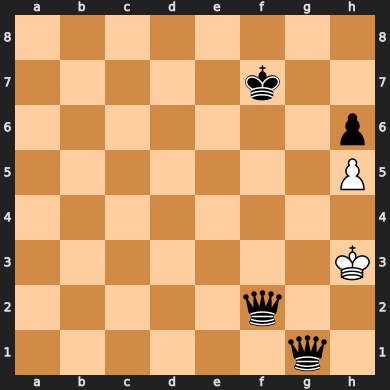

In [ ]:
display(chess.Board(pgn[-1][-1]))


In [16]:
## qua creo il dataset grosso
file = open("partite.csv", "w")

writer = csv.writer(file)

columns = ["Time", "Game", "Player", "Statistics", "Value"]
writer.writerow(columns)

#pseudo code
# to do create queste cose così da poter iterare in questa roba della morte e creare un dataset di questo tipo
# https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/realwage.csv




lista_partite = []
gamecount = 0
count = 0   
for root,dirs, files in os.walk("games"):
    if str(root)  != "games":

        partita = f"Game{root[-6:]}"
        lista_partite.append(root[-6:])
        gamecount += 1
        
    row_written = 0
    flag = False
    row_1 = []
    row_2 = []
    row_3 = [] 
    row_4 = []
    row_5 = []
    row_6 = []
    for file in files:
        #qui siamo dentro i file di una singola partita
        filename = os.fsdecode(file)
        #print(filename)
        if filename.endswith(".txt") and (filename[0] == "w" or filename[0] == "b"): # abbiamo un carissimo file delle attività
        #leggiamo i battiti
            #print(f"processando {filename}")
            player = filename[0]
            activity = read_activity(f"{str(root)}/{filename}")
            # As explained in the markdown above on our strumentation TODO our smartwatches recorded the heartbeats at different time so we smoothed it out
            for hr, time in activity:
                row = [int(time), partita, player, "HR", int(hr)]
                
                
                if filename[0] == "w":
                    row_1.append(row)
                elif filename[0] == "b": 
                    row_2.append(row)
            print("adda")
            row_written += 1
            
        elif filename.endswith(".pgn"):
            # #print(get_moves(f"{str(root)}/{filename}",), filename, partita)
            filename = filename[:-3] + "csv"
            #print(f"processando {filename}")
            
            
            with open(f"{str(root)}/{filename}", newline='') as f:
                print("leggo")
                pgn = []
                for row in csv.reader(f):
                    if row[0] == "Time":
                        continue
                    
                    tupla = eval(row[2])
                    pos = row[1]
                    lastpos = 0
                    
                    if "#" in row[1] or "Mate" in row[1]:
                        if "MateGiven" in row[1]:
                            pos = lastpos  
                        elif "-" in pos:
                            pos = -20
                            lastpos = pos
                        else:
                            pos = +20
                            lastpos = pos
                    elif float(row[1]) >= 20:
                        pos = 20
                    elif float(row[1]) <= -20:
                        pos = 20
                        # #print(row[1], pos)
                    pgn.append([int(row[0]), float(pos), (float(tupla[0]),float(tupla[0])), eval(row[3])])
                    # #print([int(row[0]), float(pos), (float(tupla[0]),float(tupla[0])), eval(row[3]) ])
                        
                print("aooo")
                pgn = pgn[1:]
                last_second = len(pgn) - 1
                    
                for second in range(len(pgn)):
                    
                    ev = pgn[second][1]
                    
                    ev = float(pgn[second][1])
                    
                    row = [second, partita, "w", "Evaluation", ev]
                    
                    row_3.append(row)
                    row = [second, partita, "b", "Evaluation", -ev]
                    row_4.append(row)
                    
                
                for second in range(len(pgn)):
                    
                    row = [second, partita, "w", "TimeUsed", int(pgn[second][2][0])]
                    row_5.append(row)
                    row = [second, partita, "b", "TimeUsed", int(pgn[second][2][1])]
                    row_6.append(row)
                    
                print("addr")
                row_written += 1
            
    print(row_written, partita)
    if row_written == 3:
        
        list_rows = [row_1,row_2,row_3,row_4, row_5, row_6]
        length = min([len(row) for row in list_rows])
        print("siuu")
        
        
        count = 0
        for i in range(6):
            
            for r in range(length):
                
                writer.writerow([count] + list_rows[i][r])
                count += 1
                
            row_written = False

print(lista_partite)



0 Game0814-2
leggo
aooo
addr


ValueError: too many values to unpack (expected 2)

In [10]:
## DATASET PER LE MOSSE
os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")

vialibera = False

gamecount = 0
count = 0   
partita = ""
with open("mosse.csv", "w") as file:
    writer = csv.writer(file)
    # TR: Time Remaining
    # T: Time in seconds from the beginning of the match
    # HRDelta: difference of the heart rate at the moment of the move
    # TPR: Time per move
    
    columns = ["MoveS","MovePGN", "Player", "TimeUsed", "Time", "Evaluation","HRDelta", "TPM", "Board", "Game", "DeltaPos", "maxi", "mini"]
    # move ok, board ok, player ok, tr ok, t ok, hrdelta ok, manca tpr
    writer.writerow(columns)
    file.close()

for root,dirs, files in os.walk("games"):
    if str(root)  != "games":
        partita = f"Game{root[-6:]}"
        gamecount += 1
        
    df = pd.read_csv("partite.csv")

    df = df.pivot_table(values='Value',
                            index='Time',
                            columns=['Game', 'Player', 'Statistics'])
    for file in files:
        #qui siamo dentro i file di una singola partita
        filename = os.fsdecode(file)
        
        #print(filename)
        
        #leggiamo i battiti
        
        if filename.endswith(".pgn"):
            vialibera = True
            filename = filename[:-3] + "csv"
            # print(f"processando {filename}")
            
        
            moves = get_moves(f"{str(root)}/{filename}")
 
            last_pos = 0.0
            added = 0
            ret = []
            # print(moves)
            with open(f"{str(root)}/{filename}", newline='') as f:
                pgn = []
                time_last_move_w = 0.0
                time_last_move_b = 0.0
                
                for row in csv.reader(f):
                    if row[0] == "Time":
                        continue
                    
                    diffw = 1
                    diffb = 1
                    move = eval(row[3])
                    
                    if move != []:
                        trem = eval(row[2])
                        # aggiungi max_delta(5 secondi da quella mossa)
                        # aggiungi differenza di posizione di mossa in mossa
                        # togli mosse che clashano
                        for _ in move:
                            if added % 2 == 0:
                                if "#" not in row[1]:
                                    delta_pos = float(row[1]) - last_pos
                                    last_pos = float(row[1])
                                else:
                                    if "-" in row[1]:
                                        delta_pos = -20 - last_pos
                                        last_pos = -20
                                    elif "+" in row[1]:
                                        delta_pos = 20 - last_pos
                                        last_pos = 20
                                try:
                                    battw = df[partita]["w"]["HR"][int(row[0])]
                                    maxi = -100
                                    mini = 100
                                    for i in range(8):
                                        try: 
                                            print(partita)
                                            maxi = max(maxi, int(df[partita]["w"]["HR"][int(row[0])]) - int(df[partita]["w"]["HR"][int(row[0]) + i]))
                                            mini = min(mini, int(df[partita]["w"]["HR"][int(row[0])]) - int(df[partita]["w"]["HR"][int(row[0]) + i]))
                                            print(f"""calcolo {maxi} {int(df[partita]["w"]["HR"][int(row[0]) + i])}""")
                                        except:
                                            maxi = max(maxi, 0)
                                            mini = min(mini, 0)
                                    if maxi == -100 and mini == 100:
                                            mini = 0
                                            maxi = 0
                                    
                                except:
                                    battw = df[partita]["w"]["HR"][int(row[0]) - diffw]
                                    diffw += 1
                                print("inserisco", maxi, mini)
                                ret.append(moves[added] + [move,"w",trem[0],int(row[0]), row[1], battw, trem[0] - time_last_move_w, row[-1], partita,  min(abs(delta_pos), 20), maxi, mini]) 
                                time_last_move_w = trem[0]
                                
                            else:
                                if "#" not in row[1]:
                                    delta_pos = last_pos - float(row[1])
                                    last_pos = float(row[1])
                                    
                                else:
                                    if "-" in row[1]:
                                        delta_pos = -20 - last_pos
                                        last_pos = -20
                                    elif "+" in row[1]:
                                        delta_pos = 20 - last_pos
                                try:
                                    battb = df[partita]["b"]["HR"][int(row[0])]
                                    maxi = -100
                                    mini = 100
                                    for i in range(8):
                                        try: 
                                            maxi = max(maxi, int(df[partita]["b"]["HR"][int(row[0])]) - int(df[partita]["b"]["HR"][int(row[0]) + i]))
                                            mini = min(mini, int(df[partita]["b"]["HR"][int(row[0])]) - int(df[partita]["b"]["HR"][int(row[0]) + i]))
                                            print(f"""calcolo {maxi} {int(df[partita]["b"]["HR"][int(row[0]) + i])}""")
                                        except:
                                            maxi = max(maxi, -5)
                                            mini = min(mini, 5)
                                            
                                        if maxi == -100 and mini == 100:
                                            mini = 0
                                            maxi = 0
                                        
                                except:
                                    battb = df[partita]["b"]["HR"][int(row[0]) - diffb]
                                    diffb += 1
                                
                                print("inserisco", maxi, mini)
                                ret.append(moves[added] + [move,"b",trem[1],int(row[0]), row[1], battb, trem[1] - time_last_move_b, row[-1], partita, min(abs(delta_pos), 20), maxi, mini])
                                time_last_move_b = trem[1]
                                
                            added += 1
                        

            if vialibera:            

                vialibera =False
                with open("mosse.csv", "a") as file:
                    writer = csv.writer(file)
                    
                    for move in ret:
                        writer.writerow(move)
                                    
                                   



Game0814-2
calcolo 0 -1
Game0814-2
calcolo 0 -1
Game0814-2
calcolo 0 0
Game0814-2
calcolo 0 0
Game0814-2
calcolo 0 1
Game0814-2
calcolo 0 1
Game0814-2
calcolo 0 2
Game0814-2
calcolo 0 2
inserisco 0 -3
calcolo 0 -1
calcolo 0 -1
calcolo 0 -1
calcolo 0 -1
calcolo 0 0
calcolo 0 2
calcolo 0 3
calcolo 0 4
inserisco 0 -5
Game0814-2
calcolo 0 2
Game0814-2
calcolo 0 2
Game0814-2
calcolo 1 1
Game0814-2
calcolo 1 1
Game0814-2
calcolo 1 1
Game0814-2
calcolo 2 0
Game0814-2
calcolo 2 0
Game0814-2
calcolo 3 -1
inserisco 3 0
calcolo 0 2
calcolo 1 1
calcolo 3 -1
calcolo 5 -3
calcolo 6 -4
calcolo 7 -5
calcolo 7 -5
calcolo 8 -6
inserisco 8 0
Game0814-2
calcolo 0 1
Game0814-2
calcolo 1 0
Game0814-2
calcolo 1 0
Game0814-2
calcolo 2 -1
Game0814-2
calcolo 2 -1
Game0814-2
calcolo 3 -2
Game0814-2
calcolo 3 -2
Game0814-2
calcolo 4 -3
inserisco 4 0
calcolo 0 -5
calcolo 1 -6
calcolo 1 -6
calcolo 2 -7
calcolo 2 -7
calcolo 2 -7
calcolo 2 -7
calcolo 2 -6
inserisco 2 0
Game0814-2
calcolo 0 -1
Game0814-2
calcolo 0 -1


In [4]:
import pandas as pd
df = pd.read_csv("mosse.csv")
df

,MoveS,MovePGN,Player,TimeUsed,Time,Evaluation,HRDelta,TPM,Board,Game,DeltaPos,maxi,mini
0,e4,['e2e4'],w,0.0,0,0.38,-1.0,0.0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,Game0814-2,0.38,0,-3
1,e5,['e7e5'],b,0.1,1,0.55,-1.0,0.1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,Game0814-2,0.17,0,-5
2,f3,['f2f3'],w,5.9,6,-1.07,2.0,5.9,rnbqkbnr/pppp1ppp/8/4p3/4P3/5P2/PPPP2PP/RNBQKB...,Game0814-2,1.62,3,0
3,Nf6,['g8f6'],b,2.6,9,-0.74,2.0,2.5,rnbqkb1r/pppp1ppp/5n2/4p3/4P3/5P2/PPPP2PP/RNBQ...,Game0814-2,0.33,8,0
4,d3,['d2d3'],w,7.2,10,-1.44,1.0,1.3,rnbqkb1r/pppp1ppp/5n2/4p3/4P3/3P1P2/PPP3PP/RNB...,Game0814-2,0.70,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,f6,['f7f6'],b,166.4,507,-8.89,2.0,13.6,N2k3r/pp4pp/2n2p2/4n1Q1/3qP1b1/3P4/P1P3PP/4KB1...,Game0816-2,1.65,5,0
1112,Qxg7,['g5g7'],w,346.9,514,#-2,6.0,6.7,N2k3r/pp4Qp/2n2p2/4n3/3qP1b1/3P4/P1P3PP/4KB1R ...,Game0816-2,11.11,0,-1
1113,Qe3+,['d4e3'],b,170.6,518,#-1,-4.0,4.2,N2k3r/pp4Qp/2n2p2/4n3/4P1b1/3Pq3/P1P3PP/4KB1R ...,Game0816-2,0.00,0,-2
1114,Be2,['f1e2'],w,363.4,534,#-1,3.0,16.5,N2k3r/pp4Qp/2n2p2/4n3/4P1b1/3Pq3/P1P1B1PP/4K2R...,Game0816-2,0.00,0,0


In [7]:
df2 = pd.read_csv("partite.csv")
df2

,Time,Game,Player,Statistics,Value
0,0,Game0814-2,w,HR,-1.0
1,1,Game0814-2,w,HR,-1.0
2,2,Game0814-2,w,HR,0.0
3,3,Game0814-2,w,HR,0.0
4,4,Game0814-2,w,HR,1.0
...,...,...,...,...,...
4717,782,Game0813-1,b,TimeUsed,255.0
4718,783,Game0813-1,b,TimeUsed,255.0
4719,784,Game0813-1,b,TimeUsed,255.0
4720,785,Game0813-1,b,TimeUsed,258.0


<BarContainer object of 7 artists>

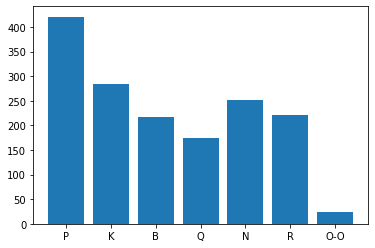

In [39]:
# Let's see what is the most played piece
mosse = df["MoveS"]
diz = {"P" : 0, "K" : 0, "B" : 0, "Q" : 0, "N" : 0, "R" : 0, "O-O": 0, "+" :0, "#": 0, "=":0 }
for mossa in mosse:
    
    if mossa[0].islower(): # è un pedone 
        diz["P"] += 1
    elif mossa[0] in list(diz.keys()):
        diz[mossa[0]] += 1
    if "+" == mossa[-1] or "#" in mossa[-1]:
        diz[mossa[-1]] += 1
    elif "=" in mossa:
        diz["="] += 1
    elif "O-" in mossa:
        diz["O-O"] += 1

plt.bar(list(diz.keys())[:7],list(diz.values())[:7])

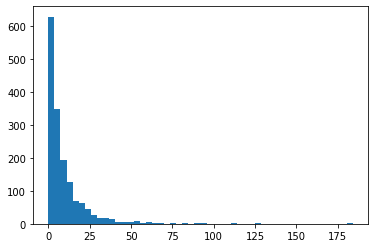

In [40]:
n, bins, patches = plt.hist(df["TPM"], bins = 50)

In [ ]:
plt.scatter(df["TPM"],df[""])

/Users/tommasodimario/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommasodimario/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  9.,  53.,  87., 190., 260., 323., 120., 169., 121.,  86.,  54.,
         32.,  22.,  21.,  10.,   4.,  11.,   6.,   0.,   1.]),
 array([-15.  , -12.15,  -9.3 ,  -6.45,  -3.6 ,  -0.75,   2.1 ,   4.95,
          7.8 ,  10.65,  13.5 ,  16.35,  19.2 ,  22.05,  24.9 ,  27.75,
         30.6 ,  33.45,  36.3 ,  39.15,  42.  ]),
 <BarContainer object of 20 artists>)

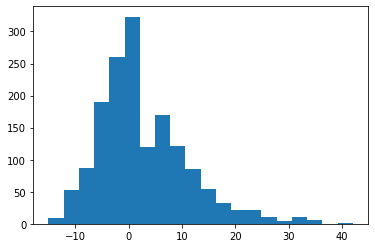

In [29]:
plt.hist(df["HRDelta"], bins = 20)

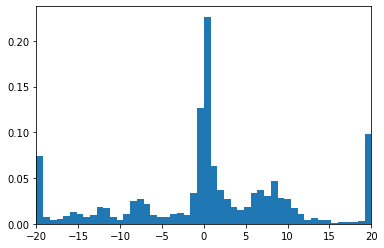

In [41]:
val = np.array(df["Evaluation"])
# n, bins, patches = plt.hist(df["Evaluation"])
# plt.xticks(bins)
for i in range(len(val)):
    if "#-" in val[i]:
        val[i] = -20
    elif "#+" in val[i]:
        val[i] = 20
    else:
        
        tmpval = float(val[i])
        if tmpval > 20:
            tmpval = 20
        elif tmpval < -20:
            tmpval = -20
        val[i] = tmpval
plt.xlim(-20,20)
n, bins, patches = plt.hist(val, density=1, bins = 50)

In [9]:
plt.scatter(df["HRDelta"], val)

NameError: name 'val' is not defined

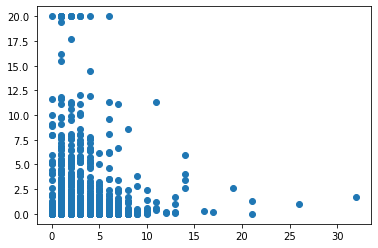

In [10]:
plt.scatter(df["maxi"], df["DeltaPos"])


Now we see that this, being really chaotic is quite a mess and actually pretty open to interpretation we remove the variables that have conflicts in the 5 seconds range

In [24]:
# Create a dataset with only the two variables 
df[["maxi", "mini", "DeltaPos", "HRDelta"]].head(20)

,maxi,mini,DeltaPos,HRDelta
0,0,-3,0.38,-1.0
1,0,-5,0.17,-1.0
2,3,0,1.62,2.0
3,8,0,0.33,2.0
4,4,0,0.70,1.0
5,2,0,0.00,-5.0
6,0,-1,0.11,-1.0
7,6,0,1.43,3.0
8,0,0,0.09,-3.0
9,2,-1,0.35,-1.0


-2

In [ ]:
max(df["MaxDeltaHR"])

100.0

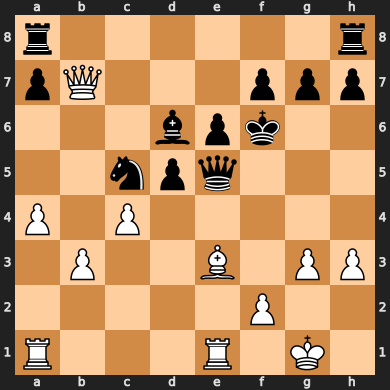

In [ ]:
# The most played move:
for row in df.iterrows():
    if row[1]["TPR"] == 240:
        display(chess.Board(row[1]["Board"]))
    

In [ ]:
#Adesso che abbiamo i dettagli delle mosse ci ripeschiamo dal dataset madre il battito al tempo della mossa
realwage = pd.read_csv("prova.csv")

realwage = realwage.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])

## ora dobbiamo aggiungere a ogni mossa



In [ ]:

# Display 6 columns for viewing purposes
# pd.set_option('display.max_columns', 6)

# Reduce decimal points to 2
# pd.options.display.float_format = '{:,.2f}'.format

realwage = pd.read_csv("prova.csv")
realwage = realwage.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])
realwage

Game       Game0529-1                                        Game0529-2       \
Player              b                        w                        b        
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed Evaluation   HR   
Time                                                                           
0               -0.55 -2.0      0.0       0.55  4.0      0.0      -0.40 -3.0   
1               -0.55 -1.0      0.0       0.55  3.0      0.0      -0.40 -3.0   
2               -0.55 -2.0      0.0       0.55  2.0      0.0      -0.40 -2.0   
3               -0.45 -1.0      3.0       0.45  1.0      3.0      -0.45 -2.0   
4               -0.45  0.0      3.0       0.45  0.0      3.0      -0.31 -1.0   
...               ...  ...      ...        ...  ...      ...        ...  ...   
1184              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1185              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1186              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1187              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1188              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   

Game                            ... Game0816-6                           \
Player                       w  ...          b          w                 
Statistics TimeUsed Evaluation  ...   TimeUsed Evaluation   HR TimeUsed   
Time                            ...                                       
0               0.0       0.40  ...        0.0       0.42 -2.0      0.0   
1               0.0       0.40  ...        0.0       0.42  0.0      0.0   
2               0.0       0.40  ...        0.0       0.42  0.0      0.0   
3               3.0       0.45  ...        0.0       0.42  1.0      0.0   
4               3.0       0.31  ...        0.0       0.42  1.0      0.0   
...             ...        ...  ...        ...        ...  ...      ...   
1184            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1185            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1186            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1187            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1188            NaN        NaN  ...        NaN        NaN  NaN      NaN   

Game       Game0816-7                                         
Player              b                        w                
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed  
Time                                                          
0               -0.35 -4.0      0.0       0.35 -2.0      0.0  
1               -0.35 -3.0      0.0       0.35 -2.0      0.0  
2               -0.35 -2.0      0.0       0.35 -1.0      0.0  
3               -0.24 -2.0      3.0       0.24 -1.0      3.0  
4               -0.75 -1.0      3.0       0.75  1.0      3.0  
...               ...  ...      ...        ...  ...      ...  
1184             0.08  7.0    592.0      -0.08  6.0    592.0  
1185             0.08  7.0    592.0      -0.08  6.0    592.0  
1186             0.39  7.0    599.0      -0.39  7.0    599.0  
1187             0.39  7.0    599.0      -0.39  7.0    599.0  
1188             5.75  7.0    599.0      -5.75  7.0    599.0  

[1189 rows x 102 columns]

In [ ]:
realwage["Game0"]

KeyError: 'Game0'